Why should I understand backpropagation:

- Vanishing non-linearities
    As explored in the previous code, sigmoids can cause vanishing gradients as large initial weights can push inputs into saturated regions of the curve (the flat parts). Since the derivative is near zero, the neuron recieves near zero gradient, effectively freezing the neuron and potential learning.

- Dying ReLUs
- Exploding gradients in RNNs
- Clipping values instead of using a proper loss function

What good would redoing the mlp code with manual backprop bring us:

- good exercise
- better at debugging netwroks
- understand what you are doing
- you won't be nervous about whats hidden away from u
- emerge stronger

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#to read the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
block_size = 3 # this represents how many letters of context the model considers before choosing the next letter

def build_dataset(words):
    X, Y = [], []

    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
#compare our gradients to pytorch gradients to see if we are accurate
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [6]:
# from the previous code
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 64 # number of neurons in the hidden layers

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g) #embeddings
#layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size) ** 0.5)# * 0.2 # best number to put this is divide by fanin (sqrt(n_embd * block_size))
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
#layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1 # sometimes when implemented as zero, it can mask the gradients

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
# bnmean_running = torch.zeros((1, n_hidden))
# bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [7]:
batch_size = 32
n = batch_size
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [8]:
emb = C[Xb] # embeds characters into vectors
embcat = emb.view(emb.shape[0], -1) #concatenate vectors
# linear layer
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# Batch norm layer
bnmeani = hprebn.sum(0, keepdim=True) * 1/n
bndiff = hprebn - bnmeani
bndiff2 = bndiff ** 2
bnvar = 1/(n-1) * bndiff2.sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5) ** -0.5
bnraw = bndiff * bnvar_inv
#bnstdi = hprebn.std(0, keepdim=True)
hpreact = bngain * bnraw + bnbias # batch normalization
# Non-linearity activation
h = torch.tanh(hpreact) # hidden layer
# Linear Layer 2
logits = h @ W2 + b2 # output
#cross entropy loss written out : loss = F.cross_entropy(logits, Ytr[ix]) # loss
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

#Pytorch back pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
        norm_logits, logit_maxes, logits, h, hpreact, bnraw,
        bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
        embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3396, grad_fn=<NegBackward0>)

In [9]:
emb.shape, C.shape, Xb.shape#, W1.shape

(torch.Size([32, 3, 10]), torch.Size([27, 10]), torch.Size([32, 3]))

In [10]:
# Exercise 1: backpropagate through everything manually
# backpropagating through every single variable 
# as they are defined in the forward pass one by one

# YOUR CODE HERE :)
# 
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = 1.0/probs * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts_sum = -counts_sum**-2 * dcounts_sum_inv
dcounts = counts_sum_inv * dprobs + dcounts_sum * torch.ones_like(counts)
dnorm_logits = counts * dcounts
dlogit_maxes = -dnorm_logits.sum(1, keepdim=True)
dlogits = dnorm_logits + F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T 
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnbias = dhpreact.sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5 * (bnvar + 1e-5) ** -1.5) * dbnvar_inv
dbndiff2 = 1/(n-1) * dbnvar * torch.ones_like(bndiff2)
dbndiff = bnvar_inv * dbnraw + (2 * bndiff * dbndiff2)
dbnmeani = -(dbndiff.sum(0, keepdim=True))
dhprebn = dbndiff + (1/n * dbnmeani * torch.ones_like(hprebn))
dembcat = dhprebn @ W1.T 
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bngain          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
bnbias          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
bnraw   

In [11]:


# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3396246433258057 diff: 2.384185791015625e-07


In [12]:
# backward pass

# YOUR CODE HERE :)
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9


logits          | exact: False | approximate: True  | maxdiff: 6.28642737865448e-09


### **Gradient of Cross-Entropy Loss with Softmax**

We consider the cross-entropy loss applied to the output of a softmax:

$$
L(z, y) = -\log\left( \frac{e^{z_y}}{\sum_{k=1}^C e^{z_k}} \right)
$$

Let $ z \in \mathbb{R}^C $ be the logits vector for a single sample with $ C $ classes, and let $ y \in \{0, \dots, C-1\} $ be the index of the correct class.

Define the softmax:

$$
p_j = \text{softmax}(z)_j = \frac{e^{z_j}}{\sum_{k=1}^C e^{z_k}} = \frac{e^{z_j}}{S}, \quad \text{where } S = \sum_{k=1}^C e^{z_k}
$$

Then the cross-entropy loss becomes:

$$
L(z, y) = -\log(p_y) = -\log\left( \frac{e^{z_y}}{S} \right) = -z_y + \log\left( \sum_{k=1}^C e^{z_k} \right)
$$

---

### **Gradient with Respect to Logits $ z_j $**

We compute:

$$
\frac{\partial L}{\partial z_j} = \frac{\partial}{\partial z_j} \left( \log\left( \sum_{k=1}^C e^{z_k} \right) - z_y \right)
$$

This separates into two parts:

#### 1. Derivative of the log-sum-exp term:

$$
\frac{\partial}{\partial z_j} \log\left( \sum_{k=1}^C e^{z_k} \right)
= \frac{1}{\sum_{k=1}^C e^{z_k}} \cdot \frac{\partial}{\partial z_j} \left( \sum_{k=1}^C e^{z_k} \right)
= \frac{e^{z_j}}{\sum_{k=1}^C e^{z_k}} = p_j
$$

#### 2. Derivative of the correct class term:

$$
\frac{\partial}{\partial z_j} (-z_y) =
\begin{cases}
-1 & \text{if } j = y \\
0 & \text{otherwise}
\end{cases}
= -\delta_{jy}
$$

---

### **Final Gradient (Per Sample)**

Combining both terms:

$$
\frac{\partial L}{\partial z_j} = p_j - \delta_{jy}
$$

In vector form:

$$
\nabla_z L = \text{softmax}(z) - \text{one\_hot}(y)
$$

---

### **Batch Case**

For a batch of $ n $ samples:

$$
\text{Loss} = \frac{1}{n} \sum_{i=1}^n L(z^{(i)}, y^{(i)})
$$

The corresponding gradient is:

$$
\frac{1}{n} \sum_{i=1}^n \left( \text{softmax}(z^{(i)}) - \text{one\_hot}(y^{(i)}) \right)
$$

Which can be implemented in PyTorch as:

```python
dlogits = F.softmax(logits, dim=1)
dlogits[range(n), Yb] -= 1
dlogits /= n


In [13]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [14]:
F.softmax(logits, 1)[0]

tensor([0.0710, 0.0880, 0.0186, 0.0500, 0.0196, 0.0826, 0.0242, 0.0358, 0.0180,
        0.0315, 0.0370, 0.0364, 0.0371, 0.0287, 0.0349, 0.0137, 0.0091, 0.0194,
        0.0158, 0.0541, 0.0500, 0.0215, 0.0253, 0.0711, 0.0590, 0.0260, 0.0215],
       grad_fn=<SelectBackward0>)

In [15]:
dlogits[0] * n

tensor([ 0.0710,  0.0880,  0.0186,  0.0500,  0.0196,  0.0826,  0.0242,  0.0358,
        -0.9820,  0.0315,  0.0370,  0.0364,  0.0371,  0.0287,  0.0349,  0.0137,
         0.0091,  0.0194,  0.0158,  0.0541,  0.0500,  0.0215,  0.0253,  0.0711,
         0.0590,  0.0260,  0.0215], grad_fn=<MulBackward0>)

In [16]:
dlogits[0].sum()

tensor(3.4925e-09, grad_fn=<SumBackward0>)

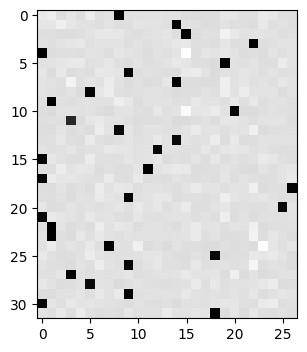

In [17]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray')

In [18]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(2.3842e-07, grad_fn=<MaxBackward1>)


In [19]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# YOUR CODE HERE :)
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


### Backpropagation through Batch Normalization: Step-by-Step Derivation

This is a derivation of the **backpropagation for batch normalization**, specifically calculating gradients of the loss with respect to the input $x_i$.

---

#### Big Picture: What’s Going On

Batch norm:

1. Normalize input $x_i$ using batch mean $\mu$ and variance $\sigma^2$.
2. Then scale and shift using parameters $\gamma, \beta$.

Forward pass:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}, \quad y_i = \gamma \hat{x}_i + \beta
$$

Goal: compute

$$
\frac{\partial L}{\partial x_i}
$$

---

#### Step 0: Definitions

- $\mu = \frac{1}{m} \sum_i x_i$ (batch mean)  
- $\sigma^2 = \frac{1}{m-1} \sum_i (x_i - \mu)^2$ (batch variance)  
- $\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}$ (normalized)  
- $y_i = \gamma \hat{x}_i + \beta$ (scaled and shifted output)  

---

#### Step 1: Chain Rule for $\frac{\partial L}{\partial x_i}$

$$
\frac{\partial L}{\partial x_i} = \frac{\partial L}{\partial \hat{x}_i} \frac{\partial \hat{x}_i}{\partial x_i} + \frac{\partial L}{\partial \mu} \frac{\partial \mu}{\partial x_i} + \frac{\partial L}{\partial \sigma^2} \frac{\partial \sigma^2}{\partial x_i}
$$

---

#### Step 2: Derivative w.r.t. $\hat{x}_i$

$$
\frac{\partial L}{\partial \hat{x}_i} = \frac{\partial L}{\partial y_i} \cdot \gamma
$$

---

#### Step 3: Derivative w.r.t. Variance $\sigma^2$

$$
\frac{\partial L}{\partial \sigma^2} = \sum_j \frac{\partial L}{\partial \hat{x}_j} \cdot \gamma \cdot (x_j - \mu) \cdot \left(-\frac{1}{2}\right) (\sigma^2 + \epsilon)^{-3/2}
$$

---

#### Step 4: Derivative w.r.t. Mean $\mu$

$$
\frac{\partial L}{\partial \mu} = \sum_j \frac{\partial L}{\partial \hat{x}_j} \cdot \gamma \cdot (-1) (\sigma^2 + \epsilon)^{-1/2} + \frac{\partial L}{\partial \sigma^2} \cdot \frac{-2}{m-1} \sum_i (x_i - \mu)
$$

---

#### Step 5: Combine all to get $\frac{\partial L}{\partial x_i}$

$$
\frac{\partial L}{\partial x_i} = \frac{\partial L}{\partial \hat{x}_i} \cdot \frac{1}{\sqrt{\sigma^2 + \epsilon}} + \frac{\partial L}{\partial \sigma^2} \cdot \frac{2}{m-1}(x_i - \mu) + \frac{\partial L}{\partial \mu} \cdot \frac{1}{m}
$$

---

#### Final Simplified Formula

$$
\frac{\partial L}{\partial x_i} = \gamma (\sigma^2 + \epsilon)^{-\frac{1}{2}} \left[ \frac{\partial L}{\partial \hat{x}_i} - \frac{1}{m} \sum_j \frac{\partial L}{\partial \hat{x}_j} - \frac{x_i - \mu}{\sigma^2 + \epsilon} \cdot \frac{1}{m} \sum_j \frac{\partial L}{\partial \hat{x}_j} (x_j - \mu) \right]
$$




In [22]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
        for j in range(Xb.shape[1]):
            ix = Xb[k,j]
            dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break

12297
      0/ 200000: 3.7931
  10000/ 200000: 2.1890
  20000/ 200000: 2.4020
  30000/ 200000: 2.4839
  40000/ 200000: 1.9834
  50000/ 200000: 2.4230
  60000/ 200000: 2.4006
  70000/ 200000: 2.0099
  80000/ 200000: 2.3982
  90000/ 200000: 2.1853
 100000/ 200000: 1.9021
 110000/ 200000: 2.3510
 120000/ 200000: 1.9526
 130000/ 200000: 2.4242
 140000/ 200000: 2.2631


KeyboardInterrupt: 

In [23]:
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [24]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.0732405185699463
val 2.1073310375213623


In [25]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # ------------
        # forward pass:
        # Embedding
        emb = C[torch.tensor([context])] # (1,block_size,d)      
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
        h = torch.tanh(hpreact) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        # ------------
        # Sample
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))


mona.
kayah.
seel.
ndhayla.
reisha.
ejdrie.
cadered.
elin.
shi.
jen.
eden.
estanaraelyzion.
kalin.
shubergshiriel.
kindreelyn.
jose.
casube.
geder.
yarue.
els.
